In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from IPython.display import HTML, display, Image

import warnings
warnings.filterwarnings('ignore')

# Evaluation of probe sets

Spapros provides metrics to evaluate the quality of a gene panel. For evaluation, we mainly focus on 2 metric categories: general variation recovery and cell type classification. Additionally as a 3rd category we measure gene redundancy based on correlation between gene pairs. In each category we further distinguish between metrics that measure different aspects: 
- Cell type identification metrics measure *cell type classification accuracy* and the *percentage of captured cell types* (and additionally - if a curated marker list is provided - how well the marker expressions of a literature derived list are captured, via *marker correlation* and *cell type balanced marker correlation*). 
- Variation recovery metrics measure how well cellular variation of the full transcriptome is recovered with only a subset of features. These comprise *coarse* and *fine clustering similarity*, which quantify how well the gene set recovers cluster structure at different levels of granularity, and *neighborhood similarity*, which measures how well the local cell neighborhoods are preserved. 
- The amount of redundant genes in the gene set is assessed via *gene correlation* and the *percentage of highly correlated genes*

The evaluation pipeline measures summary metrics for each category. We can also get more detailed information (e.g. classification accuracy of each individual cell type). These fine grained evaluations are showcased in the [advanced evaluation tutorial](./spapros_tutorial_advanced_evaluation.html).

In this tutorial we show how to compare different gene sets based on the calculation of summary metrics.
We examplary evaluate the probeset of 20 genes that was selected in our [basic selection tutoral](./spapros_tutorial_basic_selection.html).

The following figure shows how the comparison of multiple selections can look like. As mentioned we'll concentrate on the three categories: variation recovery (green), cell type classification (violet),  and gene redundancy (blue).


## Import packages and setup

In [3]:
import scanpy as sc
import spapros as sp

In [4]:
sc.settings.verbosity = 1
sc.logging.print_header()
print(f"spapros=={sp.__version__}")

spapros==0.1.5


## Load dataset

In [5]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()

# Get infos from the processed dataset
adata = adata[adata_tmp.obs_names, adata_tmp.var_names]
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata.obsm['X_umap'] = adata_tmp.obsm['X_umap']
del adata_tmp

# Preprocess counts and get highly variable genes
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=1000)

adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

## Get probesets

In [6]:
# Probeset (selected with Spapros, see basic selection tutorial)
probeset = [
    'PF4', 'HLA-DPB1', 'FCGR3A', 'GZMB', 'CCL5', 'S100A8', 'IL32', 'HLA-DQA1', 'NKG7', 'AIF1', 'CD79A', 'LTB', 'TYROBP',
    'HLA-DMA', 'GZMK', 'HLA-DRB1', 'FCN1', 'S100A11', 'GNLY', 'GZMH'
]

# Reference probesets
reference_sets = sp.se.select_reference_probesets(adata, n=20)

Reference probeset selection.............................. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:08:13
  Selecting PCA genes..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:01
  Selecting DE genes...................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:07:34
  Selecting HVG genes..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:37
  Selecting random (seed=0) genes......................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
Finished

## Evaluate sets

In [7]:
evaluator = sp.ev.ProbesetEvaluator(adata, verbosity=2, results_dir="spapros_evaluation_basic")

In [8]:
evaluator.evaluate_probeset(probeset, set_id="Spapros")

SPAPROS PROBESET EVALUATION:                                                                     0:05:43
Shared metric computations................................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:02:51
  Computing shared compuations for knn_overlap............ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   6/6 0:02:38
  Computing shared compuations for gene_corr.............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:01
Probeset specific pre computations........................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:02:39
  Computing pre compuations for knn_overlap............... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   6/6 0:02:39
Final probeset specific computations...................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:12
  Computing final compuations for knn_overlap............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   6/6 0:00:00
  Computing final compuations for forest_clfs............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25/25 0:00:11
  Computing final compuations for gene_corr............... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

In [9]:
for set_id, df in reference_sets.items():
    gene_set = df[df["selection"]].index.to_list()
    evaluator.evaluate_probeset(gene_set, set_id=set_id)


SPAPROS PROBESET EVALUATION:                                                                     0:02:52
Shared metric computations................................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:01
  Loading shared computations for knn_overlap............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading shared computations for gene_corr............... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:01
Probeset specific pre computations........................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:02:41
  Computing pre compuations for knn_overlap............... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   6/6 0:02:41
Final probeset specific computations...................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:09
  Computing final compuations for knn_overlap............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   6/6 0:00:00
  Computing final compuations for forest_clfs............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25/25 0:00:09
  Computing final compuations for gene_corr............... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

In [10]:
evaluator.summary_results


,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8
Spapros,0.167584,0.924281,0.990460,0.772479,0.993647
PCA,0.293958,0.889057,0.904067,0.820372,1.000000
DE,0.160016,0.917495,0.958829,0.757868,0.792178
HVG,0.056396,0.819224,0.720651,0.840755,0.900000
random (seed=0),0.023851,0.575790,0.003333,0.976067,1.000000


## Visualize the results

In [11]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 60

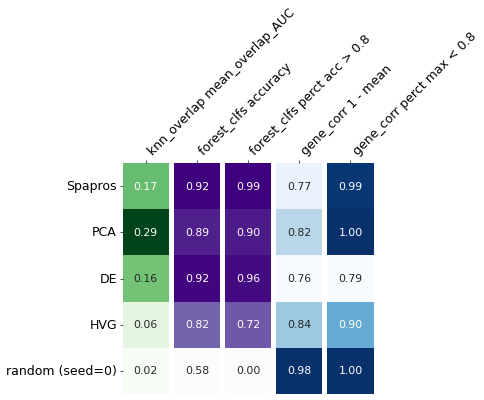

In [12]:
evaluator.plot_summary()

In the generated summary table we see that the selection based on PCA shows the highest (fine level) variation recovery and Spapros shows the highest cell type classification accuracy. 

Note that we didn't measure all metrics in this tutorial since the `ProbesetEvaluator` sets as a default argument `scheme='quick'`. In the advanced evaluation tutorial we showcase how to adjust the evaluation and then go into more detailed comparisons.

**Note**:
After running the spapros evaluation pipeline, the results are stored in a directory, that is by default called `probeset_evaluation`.
If you run another evaluation after this tutorial, be careful that you either specify another dir or delete the previously created results directory because otherwise parts will be overwritten and parts will be falsely reused!
If you do not want to save results, initialize the `ProbesetEvaluator` with `dir=None`, like in this tutorial.

## What's next?

[advanced evaluation tutorial](./tutorials/spapros_tutorial_advanced_evaluation.html)